In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm
from acn_experiments.run_simulation import run_simulations, metrics

In [ ]:
from gymportal.data.ev_generators import get_standard_generator, RealWorldGenerator
from acnportal.acnsim import Linear2StageBattery
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from icecream import ic

import pytz
timezone = pytz.timezone("America/Los_Angeles")

# charging_network = get_charging_network('simple_acn', basic_evse=True, voltage=208,
                                        # network_kwargs={
                                            # 'station_ids': ['CA-504', 'CA-503', 'CA-502', 'CA-501'],
                                             #'station_ids': ['CA-501'],
# "aggregate_cap": 32 * 208 / 1000})

charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
                                        network_kwargs={"transformer_cap": 40 * 32 * 208 / 1000})

battery_generator = CustomizableBatteryGenerator(voltage=208,
                                                 period=1,
                                                 battery_types=[
                                                     Linear2StageBattery],
                                                 max_power_function='normal')

ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
# ev_generator = get_standard_generator('caltech', battery_generator, seed=42)

train_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=7,
    n_intervals=46,
    start_date=timezone.localize(datetime(2019, 1, 1)),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(train_generator.end_date + timedelta(days=1))

eval_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=7,
    n_intervals=1,
    start_date=train_generator.end_date + timedelta(days=1),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(eval_generator.end_date + timedelta(days=1))

validation_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=14,
    n_intervals=1,
    start_date=eval_generator.end_date + timedelta(days=1),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(validation_generator.end_date + timedelta(days=1))
pass

ic| train_generator.end_date + timedelta(days=1): datetime.datetime(2019, 11, 20, 0, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>)
ic| eval_generator.end_date + timedelta(days=1): datetime.datetime(2019, 11, 28, 0, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>)
ic| validation_generator.end_date + timedelta(days=1): datetime.datetime(2019, 12, 13, 0, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>)


In [3]:
from gymportal.environment import *
from src.extra import unplug_penalty, ranking_schedule_plus


observation_objects = [
    charging_rates_observation_normalized(),
    percentage_of_magnitude_observation(),
    diff_pilots_charging_rates_observation_normalized(),
    cyclical_minute_observation(),
    cyclical_day_observation(),
    cyclical_month_observation(),
    cyclical_minute_observation_stay(),
    energy_delivered_observation_normalized(),
    num_active_stations_observation_normalized(),
    pilot_signals_observation_normalized(),
    cyclical_minute_observation_arrival(),
    cyclical_day_observation_arrival(),
    cyclical_month_observation_arrival(),
]

reward_objects = [
    # current_constraint_violation(),
    # soft_charging_reward(),
    constraint_charging_reward(),
    unplug_penalty(),
    # pilot_charging_rate_difference_penalty(),
]

In [4]:

train_config = {"observation_objects": observation_objects, "action_object": ranking_schedule_plus(),
                "reward_objects": reward_objects,
                "simgenerator": train_generator,
                "meet_constraints": False}

eval_config = train_config | {'simgenerator': eval_generator}
validation_config = train_config | {'simgenerator': validation_generator}

In [5]:
from acn_experiments.utils import FlattenSimEnv
from src.ppo_custom.ppo_model import PPO

env = FlattenSimEnv(config=train_config)
algo = PPO(env)

In [6]:
from gymportal.evaluation import ACNSchedule, RllibSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served
from acn_experiments.utils import CustomSchedule


models = {
    "PPO": CustomSchedule(algo),
    "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
    "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
    "Uncontrolled": ACNSchedule(UncontrolledCharging()),
}

models

{'PPO': <acn_experiments.utils.CustomSchedule at 0x7fcf1f1e0b20>,
 'FCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7fcf1f1e0fd0>,
 'LCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7fcf1f1e0610>,
 'Uncontrolled': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7fcf1f1e0100>}

In [7]:
df_before = run_simulations(models, metrics=metrics, config=eval_config, seed=42)

Models:   0%|          | 0/4 [01:22<?, ?it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 4

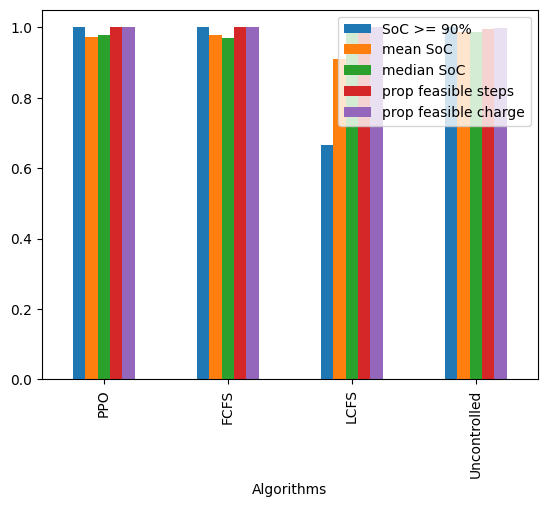

In [8]:
df_before.to_csv("before.csv")
ax = df_before.plot.bar()
fig = ax.get_figure()
fig.savefig("before.png", dpi=600)

In [ ]:
import wandb
wandb.init(project="ppo_test", name="ranking+")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tsturm (tsturm-university-kassel). Use `wandb login --relogin` to force relogin


In [10]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(log_model="all")

# model = PPO(env)
trainer = Trainer(max_epochs=3, logger=wandb_logger, accelerator="cpu", callbacks=[])
res = trainer.fit(algo)
res

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:44: Attribute 'env' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['env'])`.
/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name   | Type           | Params | Mode 
--------------------------------------------------
0 | critic | Sequential     | 23.9 K | train
1 | actor  | ActorContinous | 24.3 K | train
--------------------------------------------------
48.3 K    Trainable params
0         Non-trainable params
48.3 K    Total params
0.193     Total est

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [11]:
wandb.finish()

avg_ep_len,▁█▇
avg_ep_reward,▁█▆
avg_reward,▁█▇
epoch,▁▅█
trainer/global_step,▁▅█
avg_ep_len,221.59723
avg_ep_reward,45.41837
avg_reward,0.20753
epoch,2
trainer/global_step,11


In [12]:
from datetime import datetime

eval_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=1,
    n_intervals=1,
    start_date=timezone.localize(datetime(2019, 9, 23)),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

evaluation_config = train_config | {"simgenerator": eval_generator}

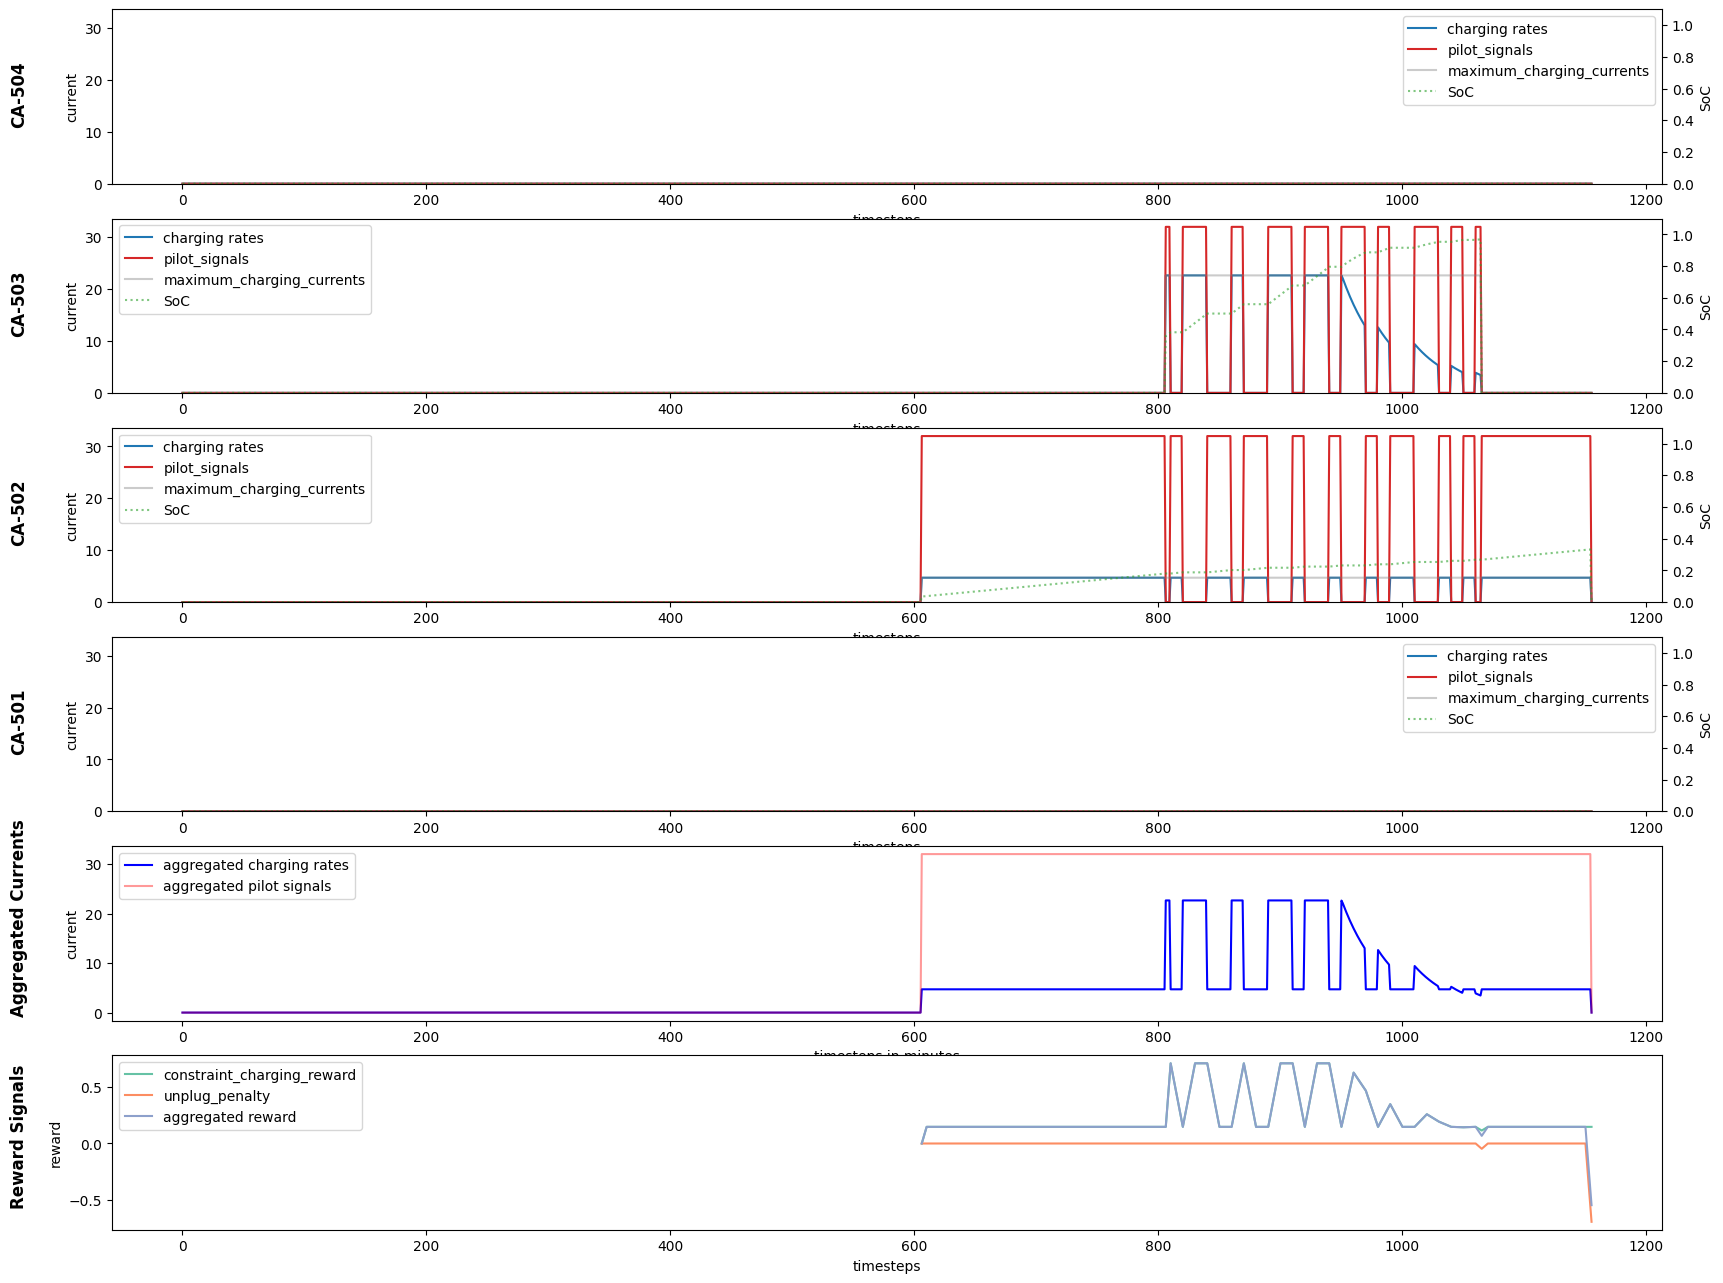

In [13]:
from gymportal.plotting.plotting import plot_sim_evaluation
from gymportal.evaluation import evaluate_model

eval_sim = evaluate_model(CustomSchedule(
    algo), env_type=FlattenSimEnv, env_config=evaluation_config)


_ = plot_sim_evaluation(eval_sim)#.savefig("evaluation.png", dpi=300)

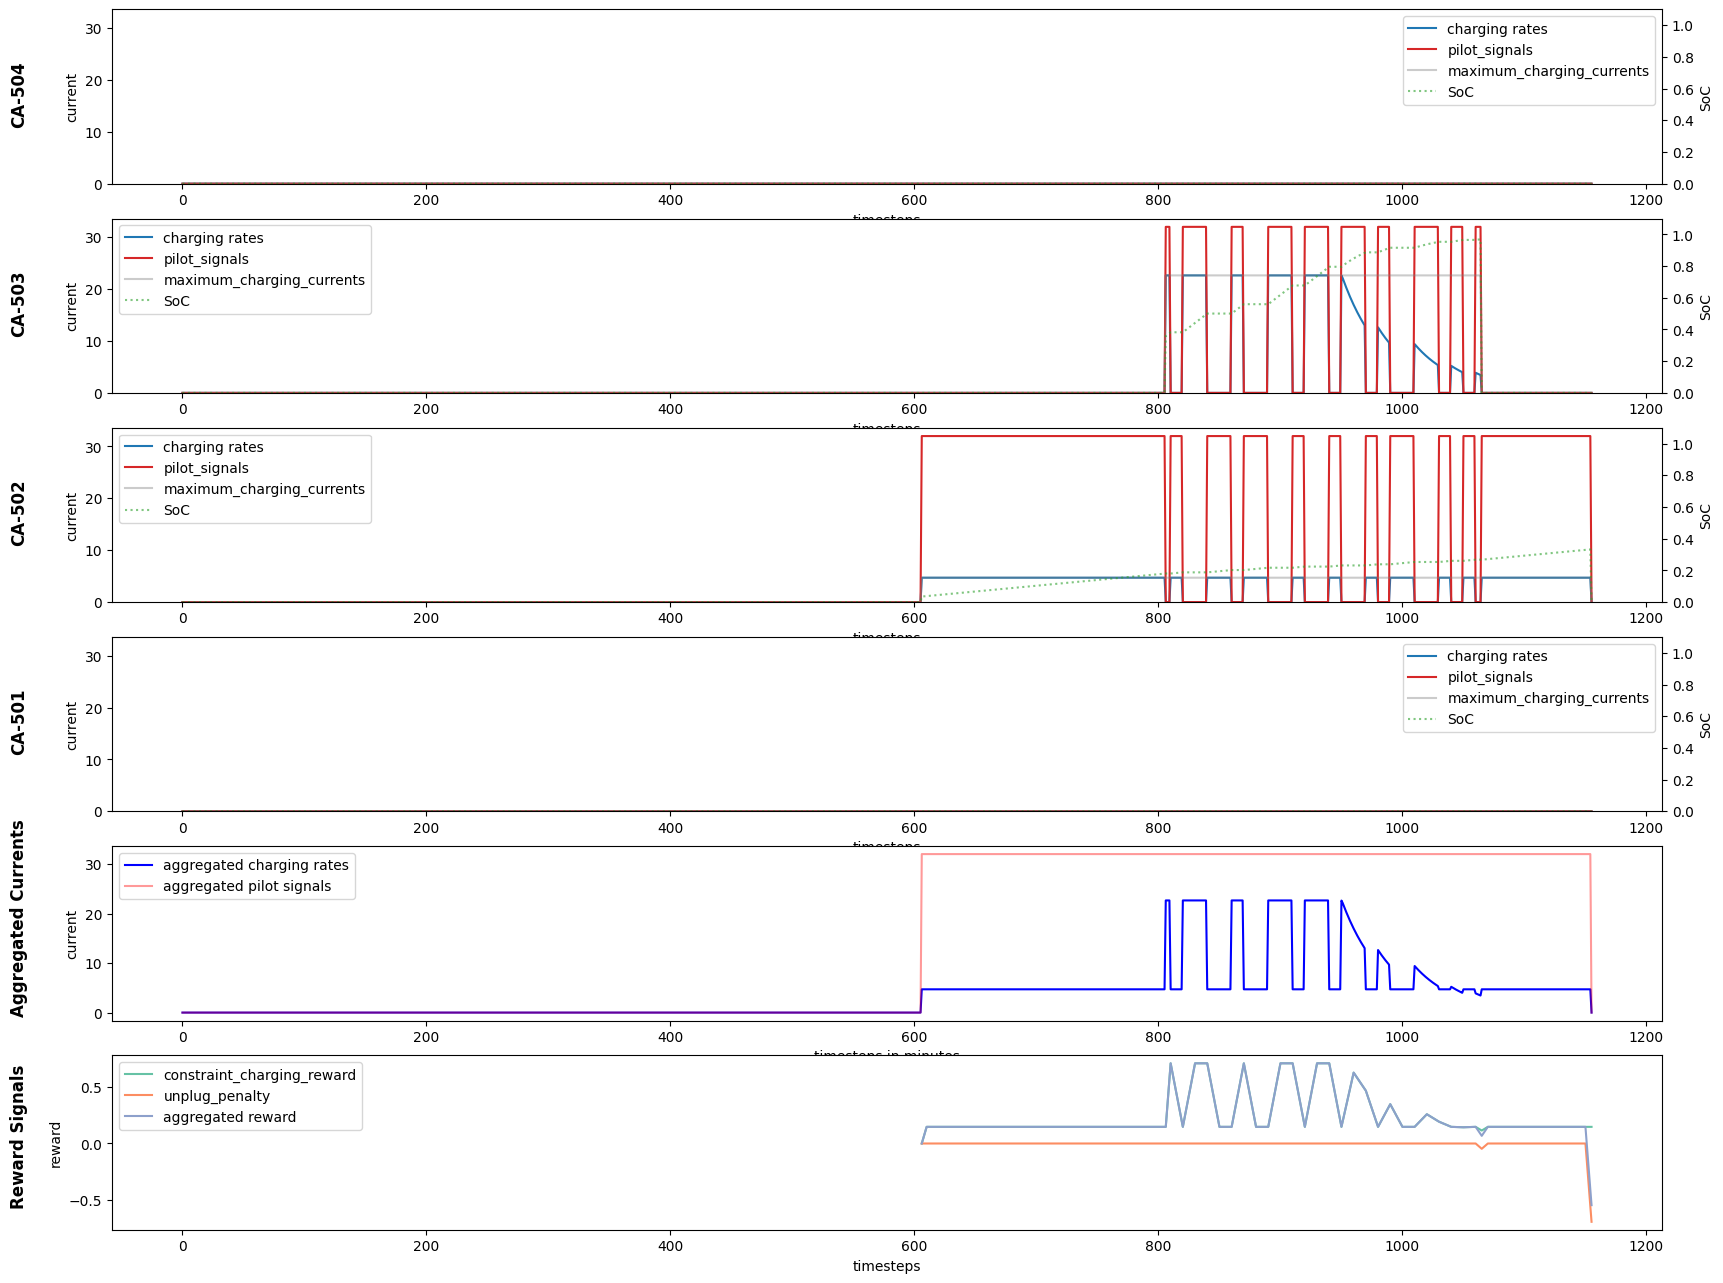

In [14]:
from gymportal.plotting.plotting import plot_sim_evaluation

_ = plot_sim_evaluation(eval_sim)

In [15]:
df_after = run_simulations(models, metrics=metrics, config=eval_config, seed=42)

Models:  25%|██▌       | 1/4 [01:22<04:08, 82.71s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models:  50%|█████     | 2/4 [02:43<02:43, 81.64s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models:  75%|███████▌  | 3/4 [04:16<01:26, 86.69s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models: 100%|██████████| 4/4 [05:35<00:00, 83.94s/it]


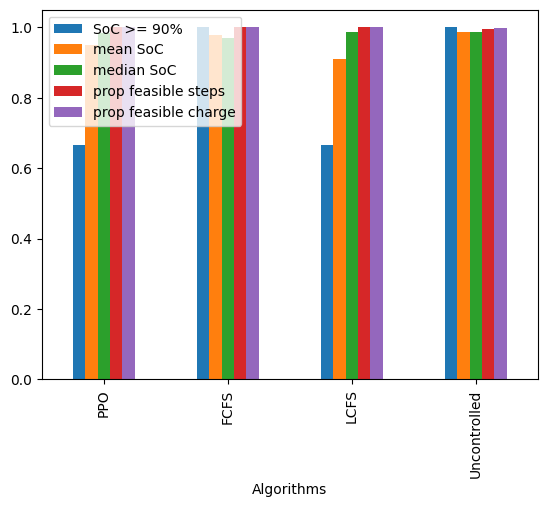

In [16]:
df_after.to_csv("after.csv")
ax = df_after.plot.bar()
fig = ax.get_figure()
fig.savefig("after.png", dpi=600)

## Before training:

In [17]:
df_before

,SoC >= 90%,mean SoC,median SoC,prop feasible steps,prop feasible charge
Algorithms,,,,,
PPO,1.000000,0.971334,0.977410,1.000000,1.000000
FCFS,1.000000,0.979617,0.969948,1.000000,1.000000
LCFS,0.666667,0.909603,0.987236,1.000000,1.000000
Uncontrolled,1.000000,0.985379,0.987236,0.996682,0.997879


## After training:

In [18]:
df_after

,SoC >= 90%,mean SoC,median SoC,prop feasible steps,prop feasible charge
Algorithms,,,,,
PPO,0.666667,0.950982,0.983019,1.000000,1.000000
FCFS,1.000000,0.979617,0.969948,1.000000,1.000000
LCFS,0.666667,0.909603,0.987236,1.000000,1.000000
Uncontrolled,1.000000,0.985379,0.987236,0.996682,0.997879
